# MTA Turnstile Data and ADA Data Analysis
The stations data with ADA information are combined with the previous MTA turnstile data to provide analysis on traffic pattern in non-ADA Stations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import urllib.request
from sqlalchemy import create_engine

### Retreive Datasets, Clean and Merge

In [2]:
# Retrieve subway station ADA info
urllib.request.urlretrieve("http://web.mta.info/developers/data/nyct/subway/Stations.csv",
                           "data/subway_stations.csv")
# Load csv file into mta.db
##Command line
"""
sqlite3 mta.db
.mode csv
.import subway_stations.csv station_data
"""


'\nsqlite3 mta.db\n.mode csv\n.import subway_stations.csv station_data\n'

Created new table merge_data by joining tables in SQL. (code can be found in [HERE](https://github.com/crystal-ctrl/EDA_MTA_Turnstile/blob/d10ca6de2d087127b37f97ef23647a39923bf833/mta_merge.sql.sqbpro))

In [3]:
# Accessing ADA data
engine = create_engine("sqlite:///data/mta.db")
ada_df = pd.read_sql('SELECT * FROM merged_data WHERE ADA IS NOT NULL;', engine)
ada_df.head()

,STATION,ADA
0,59 ST,0
1,5 AV/59 ST,0
2,57 ST-7 AV,0
3,49 ST,2
4,TIMES SQ-42 ST,0


In [4]:
# Double check on NaN values
ada_df.isna().sum()

STATION    0
ADA        0
dtype: int64

In [5]:
def ADA_fix(df):
    """
    Some station has mulitple lines with different ADA status
    Considering partial-ADA as ADA station, 
    if the stations has multiple labels,
    Only the higher label will be taken
    """
    # Sort by ADA label first (label 0: non-ADA, 1: full-ADA, 2: partial-ADA)
    df = df.sort_values('ADA', ascending=False)

    # Only taking the higher label aka the first label after values are sorted
    df = (df.groupby(['STATION'])
            .ADA.first()
            .reset_index())

    # If the station has ADA, will be count as ADA station
    ada_map = {
        "0" : False,
        "1" : True,
        "2" : True
    }
    
    df['ADA'] = df.ADA.map(ada_map)

    return df

In [6]:
ada_df = ADA_fix(ada_df)
ada_df.head()

,STATION,ADA
0,1 AV,True
1,103 ST,False
2,103 ST-CORONA,False
3,104 ST,False
4,110 ST,False


In [7]:
# Double check
ada_df[ada_df.STATION == 'TIMES SQ-42 ST']

,STATION,ADA
332,TIMES SQ-42 ST,True


In [8]:
# Accessing cleaned mta turnstile df
station_df = pd.read_csv('./data/cleaned_mta_df.csv', index_col=0)
print(station_df.shape)
station_df.head()

/Users/crystalhuang/anaconda3/envs/metis/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(10030770, 6)


,STATION,DATETIME,DAY_OF_WEEK,ENTRY_DIFF,EXIT_DIFF,TOTAL_TRAFFIC
0,59 ST,2020-03-21 04:00:00,Saturday,2.0,4.0,6.0
1,59 ST,2020-03-21 08:00:00,Saturday,3.0,13.0,16.0
2,59 ST,2020-03-21 12:00:00,Saturday,24.0,21.0,45.0
3,59 ST,2020-03-21 16:00:00,Saturday,59.0,24.0,83.0
4,59 ST,2020-03-21 20:00:00,Saturday,25.0,16.0,41.0


In [9]:
# Create DATE and TIME column for easier access later
station_df["DATE"] = pd.to_datetime(station_df['DATETIME']).dt.date
station_df["TIME"] = pd.to_datetime(station_df['DATETIME']).dt.time
station_df['DAY_OF_WEEK'] = pd.to_datetime(station_df['DATETIME']).dt.dayofweek
station_df.head()

,STATION,DATETIME,DAY_OF_WEEK,ENTRY_DIFF,EXIT_DIFF,TOTAL_TRAFFIC,DATE,TIME
0,59 ST,2020-03-21 04:00:00,5,2.0,4.0,6.0,2020-03-21,04:00:00
1,59 ST,2020-03-21 08:00:00,5,3.0,13.0,16.0,2020-03-21,08:00:00
2,59 ST,2020-03-21 12:00:00,5,24.0,21.0,45.0,2020-03-21,12:00:00
3,59 ST,2020-03-21 16:00:00,5,59.0,24.0,83.0,2020-03-21,16:00:00
4,59 ST,2020-03-21 20:00:00,5,25.0,16.0,41.0,2020-03-21,20:00:00


In [10]:
# left join table to mta turnstile data
merged_df = station_df.merge(ada_df, how='left', on='STATION')
print(merged_df.shape)
merged_df.head()

(10030770, 9)


,STATION,DATETIME,DAY_OF_WEEK,ENTRY_DIFF,EXIT_DIFF,TOTAL_TRAFFIC,DATE,TIME,ADA
0,59 ST,2020-03-21 04:00:00,5,2.0,4.0,6.0,2020-03-21,04:00:00,False
1,59 ST,2020-03-21 08:00:00,5,3.0,13.0,16.0,2020-03-21,08:00:00,False
2,59 ST,2020-03-21 12:00:00,5,24.0,21.0,45.0,2020-03-21,12:00:00,False
3,59 ST,2020-03-21 16:00:00,5,59.0,24.0,83.0,2020-03-21,16:00:00,False
4,59 ST,2020-03-21 20:00:00,5,25.0,16.0,41.0,2020-03-21,20:00:00,False


In [11]:
# Check for NaN values
merged_df.isna().sum()

STATION              0
DATETIME             0
DAY_OF_WEEK          0
ENTRY_DIFF           0
EXIT_DIFF            0
TOTAL_TRAFFIC        0
DATE                 0
TIME                 0
ADA              23753
dtype: int64

In [12]:
# See Which Stations does not have values in ADA columns
merged_df[merged_df['ADA'].isna() == 1]['STATION'].value_counts()

JFK JAMAICA CT1    20373
ORCHARD BEACH       3380
Name: STATION, dtype: int64

In [13]:
# Checking on one certain station
merged_df[merged_df.STATION == "JFK JAMAICA CT1"]
# These two station doesnt have ADA info

,STATION,DATETIME,DAY_OF_WEEK,ENTRY_DIFF,EXIT_DIFF,TOTAL_TRAFFIC,DATE,TIME,ADA
2216232,JFK JAMAICA CT1,2020-03-21 04:00:00,5,5.0,0.0,5.0,2020-03-21,04:00:00,NaN
2216233,JFK JAMAICA CT1,2020-03-21 08:00:00,5,27.0,0.0,27.0,2020-03-21,08:00:00,NaN
2216234,JFK JAMAICA CT1,2020-03-21 12:00:00,5,41.0,0.0,41.0,2020-03-21,12:00:00,NaN
2216235,JFK JAMAICA CT1,2020-03-21 16:00:00,5,57.0,0.0,57.0,2020-03-21,16:00:00,NaN
2216236,JFK JAMAICA CT1,2020-03-21 20:00:00,5,22.0,0.0,22.0,2020-03-21,20:00:00,NaN
...,...,...,...,...,...,...,...,...,...
2236600,JFK JAMAICA CT1,2021-03-19 04:00:00,4,0.0,0.0,0.0,2021-03-19,04:00:00,NaN
2236601,JFK JAMAICA CT1,2021-03-19 08:00:00,4,0.0,23.0,23.0,2021-03-19,08:00:00,NaN
2236602,JFK JAMAICA CT1,2021-03-19 12:00:00,4,0.0,17.0,17.0,2021-03-19,12:00:00,NaN
2236603,JFK JAMAICA CT1,2021-03-19 16:00:00,4,0.0,74.0,74.0,2021-03-19,16:00:00,NaN


In [14]:
# Dropping the two stations that don't have the ADA info
merged_df.dropna(subset=['ADA'],inplace=True)
merged_df.isna().sum()

STATION          0
DATETIME         0
DAY_OF_WEEK      0
ENTRY_DIFF       0
EXIT_DIFF        0
TOTAL_TRAFFIC    0
DATE             0
TIME             0
ADA              0
dtype: int64

In [15]:
non_ada_df = merged_df[merged_df.ADA == False]
non_ada_df

,STATION,DATETIME,DAY_OF_WEEK,ENTRY_DIFF,EXIT_DIFF,TOTAL_TRAFFIC,DATE,TIME,ADA
0,59 ST,2020-03-21 04:00:00,5,2.0,4.0,6.0,2020-03-21,04:00:00,False
1,59 ST,2020-03-21 08:00:00,5,3.0,13.0,16.0,2020-03-21,08:00:00,False
2,59 ST,2020-03-21 12:00:00,5,24.0,21.0,45.0,2020-03-21,12:00:00,False
3,59 ST,2020-03-21 16:00:00,5,59.0,24.0,83.0,2020-03-21,16:00:00,False
4,59 ST,2020-03-21 20:00:00,5,25.0,16.0,41.0,2020-03-21,20:00:00,False
...,...,...,...,...,...,...,...,...,...
10030765,EASTCHSTER/DYRE,2021-03-19 04:00:00,4,4.0,0.0,4.0,2021-03-19,04:00:00,False
10030766,EASTCHSTER/DYRE,2021-03-19 08:00:00,4,51.0,13.0,64.0,2021-03-19,08:00:00,False
10030767,EASTCHSTER/DYRE,2021-03-19 12:00:00,4,18.0,7.0,25.0,2021-03-19,12:00:00,False
10030768,EASTCHSTER/DYRE,2021-03-19 16:00:00,4,42.0,22.0,64.0,2021-03-19,16:00:00,False


## Initial Analysis on Distribution of Traffic Across non-ADA Stations

In [16]:
# Table for each STATION daily TOTAL TRAFFIC
station_daily = non_ada_df.groupby(["STATION","DATE"])[['TOTAL_TRAFFIC']].sum().reset_index()
station_daily.head()

,STATION,DATE,TOTAL_TRAFFIC
0,103 ST,2020-03-21,8080.0
1,103 ST,2020-03-22,6822.0
2,103 ST,2020-03-23,10516.0
3,103 ST,2020-03-24,10676.0
4,103 ST,2020-03-25,10352.0


In [17]:
# Table for each STATION sum TOTAL TRAFFIC during pandemic
"""
Sum up the total ridership for each station during pandemic and sort them based on traffic volume
to find out the traffic pattern and top 10 stations with the highest traffic during pandemic
"""
stations_total = station_daily.groupby('STATION').sum()\
    .sort_values('TOTAL_TRAFFIC', ascending=False)\
    .reset_index()

stations_total.head(10)

,STATION,TOTAL_TRAFFIC
0,59 ST,10487258.75
1,145 ST,6889627.75
2,116 ST,5690920.25
3,77 ST,5402087.25
4,103 ST,5146570.50
5,103 ST-CORONA,5134893.00
6,GRAND ST,4989870.50
7,WOODHAVEN BLVD,4569826.75
8,181 ST,4229255.25
9,42 ST-BRYANT PK,4196541.00


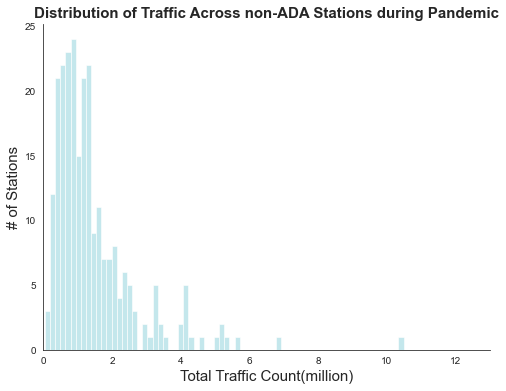

In [18]:
# Distribution Plot on ridership across stations
plt.figure(figsize=[8,6])
sns.set_style("white")
sns.histplot(stations_total['TOTAL_TRAFFIC'], bins=70, kde=False, color='powderblue')
plt.title("Distribution of Traffic Across non-ADA Stations during Pandemic",size=15,weight='bold')
plt.xlabel("Total Traffic Count(million)", size=15)
plt.ylabel("# of Stations", size=15)
plt.xlim([0,13000000])
plt.xticks(range(0,13000000,2000000),[str(int(i/1000000)) for i in range(0,13000000,2000000)])
sns.despine();

plt.savefig("DistributionOfTraffic2.png")

### 1. What are the top 10 popular non-ADA stations during pandemic?

In [19]:
station_avg = station_daily.groupby('STATION').mean().round(0)\
    .sort_values('TOTAL_TRAFFIC', ascending=False)\
    .reset_index()
# Sanity check
station_avg.head(10)

,STATION,TOTAL_TRAFFIC
0,59 ST,28811.0
1,145 ST,18928.0
2,116 ST,15634.0
3,77 ST,14841.0
4,103 ST,14139.0
5,103 ST-CORONA,14107.0
6,GRAND ST,13708.0
7,WOODHAVEN BLVD,12554.0
8,181 ST,11619.0
9,42 ST-BRYANT PK,11529.0


/Users/crystalhuang/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


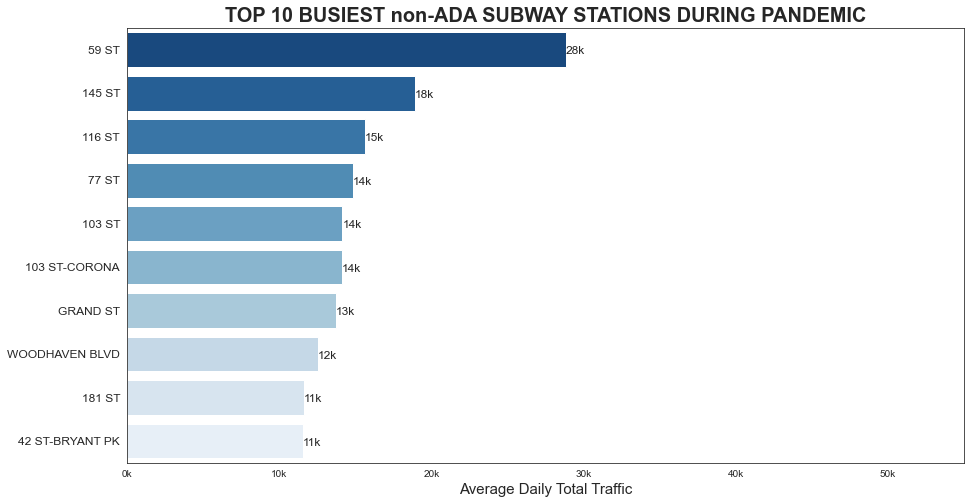

In [20]:
# Barplot for top 10 busiest subway
top_10_avg_daily = station_avg[:10]
plt.figure(figsize=[15,8])
sns.set_style("white")
palette = sns.color_palette("Blues",n_colors=10)
palette.reverse()
ax = sns.barplot('TOTAL_TRAFFIC', 'STATION', data=top_10_avg_daily, orient="horizontal", palette=palette)
plt.title('TOP 10 BUSIEST non-ADA SUBWAY STATIONS DURING PANDEMIC', size=20, weight='bold')
plt.xlabel("Average Daily Total Traffic", size=15)
plt.ylabel("")
plt.xlim([0,55000])
plt.xticks(range(0,60000,10000),[str(int(i/1000))+"k" for i in range(0,60000,10000)], size=10)
plt.yticks(size=12)
for p in ax.patches:
        ax.annotate(str(int(p.get_width()/1000))+'k', (p.get_width(), p.get_y()+0.5), size =12);

plt.savefig("Top10BusiestSubway2.png")

### 2. What is the traffic pattern in those stations? Which day of the week and what time of the day have lower ridership?

In [21]:
# Top 10 non-ADA Stations list
top10_list = list(top_10_avg_daily['STATION'])
print(top10_list)

# Top 10 non-ADA Stations df
top10_df = non_ada_df[non_ada_df['STATION'].isin(top10_list)]
top10_df.head()

['59 ST', '145 ST', '116 ST', '77 ST', '103 ST', '103 ST-CORONA', 'GRAND ST', 'WOODHAVEN BLVD', '181 ST', '42 ST-BRYANT PK']


,STATION,DATETIME,DAY_OF_WEEK,ENTRY_DIFF,EXIT_DIFF,TOTAL_TRAFFIC,DATE,TIME,ADA
0,59 ST,2020-03-21 04:00:00,5,2.0,4.0,6.0,2020-03-21,04:00:00,False
1,59 ST,2020-03-21 08:00:00,5,3.0,13.0,16.0,2020-03-21,08:00:00,False
2,59 ST,2020-03-21 12:00:00,5,24.0,21.0,45.0,2020-03-21,12:00:00,False
3,59 ST,2020-03-21 16:00:00,5,59.0,24.0,83.0,2020-03-21,16:00:00,False
4,59 ST,2020-03-21 20:00:00,5,25.0,16.0,41.0,2020-03-21,20:00:00,False


In [22]:
## Create Pivot table for Day_of_Week vs Stations traffic pattern
# Top 10 Stations daily 
top10_daily = top10_df.groupby(["STATION","DATE","DAY_OF_WEEK"])[['TOTAL_TRAFFIC']].sum().reset_index()

# Top 10 Stations avg day of week
top10_dow = top10_daily.groupby(['STATION','DAY_OF_WEEK'])['TOTAL_TRAFFIC']\
                .mean().round(0)\
                .reset_index().sort_values('TOTAL_TRAFFIC',ascending=False)

# Turn top10_dow_hm into pivot table for heatmap
top10_dow_hm = top10_dow.pivot(index=["STATION"], columns=['DAY_OF_WEEK'], values='TOTAL_TRAFFIC')
print(top10_dow_hm.columns)
top10_dow_hm.columns = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
top10_dow_hm = top10_dow_hm.reindex(top10_list)
top10_dow_hm

Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64', name='DAY_OF_WEEK')


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
STATION,,,,,,,
59 ST,31347.0,33813.0,34663.0,33147.0,32001.0,21131.0,15577.0
145 ST,19320.0,20779.0,21379.0,20783.0,21150.0,16019.0,13062.0
116 ST,16246.0,17363.0,17806.0,17262.0,17631.0,12836.0,10296.0
77 ST,16519.0,17911.0,18148.0,18111.0,17131.0,9209.0,6856.0
103 ST,15030.0,16132.0,16441.0,16045.0,15877.0,10758.0,8690.0
103 ST-CORONA,15106.0,15822.0,16100.0,15859.0,15787.0,11385.0,8689.0
GRAND ST,14622.0,15319.0,15641.0,15204.0,15569.0,11036.0,8568.0
WOODHAVEN BLVD,13359.0,14342.0,14603.0,13984.0,14053.0,9890.0,7651.0
181 ST,11975.0,13161.0,13252.0,13102.0,12903.0,9311.0,7627.0


In [23]:
## Create Pivot table for Day_of_Week vs Time_Period traffic pattern
# Timeperiod dictionary
top10_df['TIME']= top10_df.TIME.astype('str')
time_period = {
    "04:00:00": "00:00-04:00",
    "08:00:00": "04:00-08:00",
    "12:00:00": "08:00-12:00",
    "16:00:00": "12:00-16:00",
    "20:00:00": "16:00-20:00",
    "00:00:00": "20:00-00:00"
}
top10_df['TIME_PERIOD'] = top10_df.TIME.map(time_period)

# Group by Date and time for total count across the stations
top10_period = top10_df.groupby(['DATE', 'DAY_OF_WEEK', 'TIME_PERIOD'])['TOTAL_TRAFFIC']\
                        .sum().round(0).reset_index()

# Group by Day of Week and time period for the average count
period_time = top10_period.groupby(['DAY_OF_WEEK', 'TIME_PERIOD'])['TOTAL_TRAFFIC']\
                            .mean().round().reset_index()

# Pivot table for time vs day of week
time_vs_day = period_time.pivot(index=["TIME_PERIOD"], columns=['DAY_OF_WEEK'], values='TOTAL_TRAFFIC')
time_vs_day.columns = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
time_vs_day

<ipython-input-23-a2e9fce00364>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10_df['TIME']= top10_df.TIME.astype('str')
<ipython-input-23-a2e9fce00364>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top10_df['TIME_PERIOD'] = top10_df.TIME.map(time_period)


,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
TIME_PERIOD,,,,,,,
00:00-04:00,4871.0,5224.0,5242.0,4926.0,4848.0,3280.0,2539.0
04:00-08:00,32944.0,35458.0,35866.0,34331.0,32620.0,15186.0,10626.0
08:00-12:00,35694.0,38013.0,38743.0,37853.0,37065.0,25688.0,19792.0
12:00-16:00,45253.0,48039.0,49356.0,47189.0,47747.0,33785.0,26337.0
16:00-20:00,37312.0,40316.0,40802.0,39903.0,39756.0,26866.0,20819.0
20:00-00:00,9997.0,11915.0,12461.0,12990.0,12990.0,14551.0,12181.0


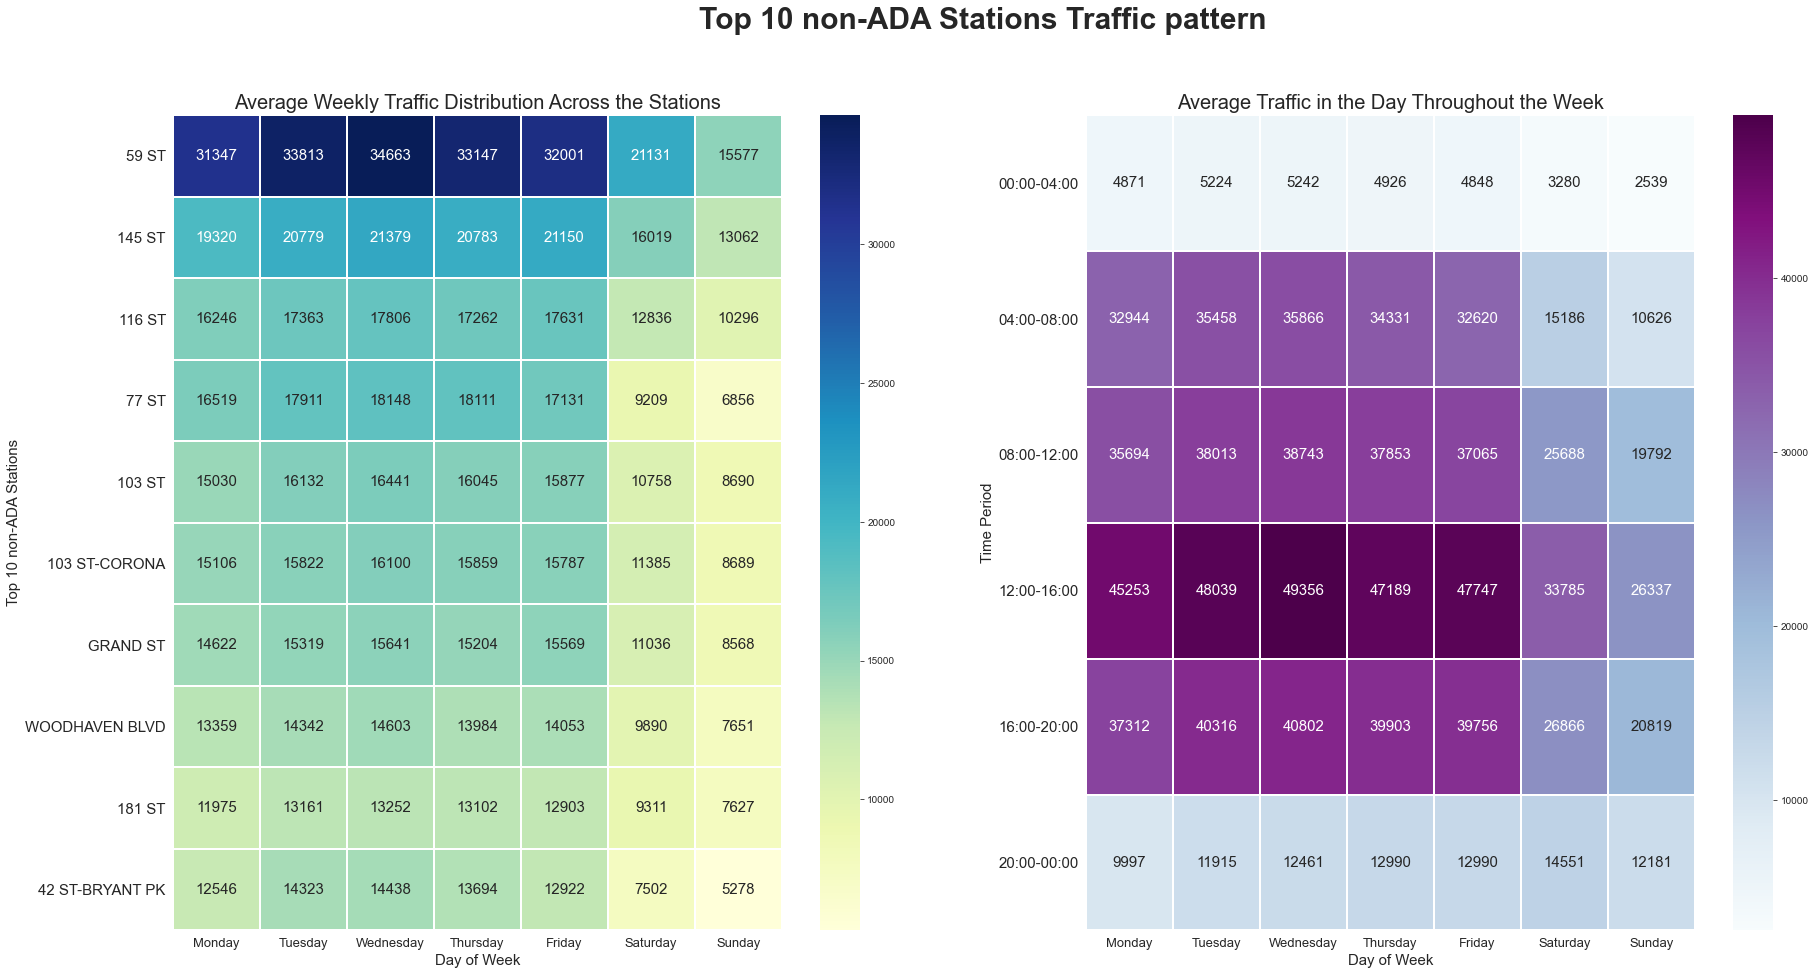

In [24]:
# Heatmaps for traffic pattern in top 10 non-ADA stations
plt.figure(figsize=[30,15])
plt.suptitle("Top 10 non-ADA Stations Traffic pattern", size=30, weight='bold')
plt.subplot(1,2,1)
sns.heatmap(top10_dow_hm, cmap='YlGnBu', linecolor='white', linewidths=1, annot=True, fmt=".0f", annot_kws={"size":15})
plt.title("Average Weekly Traffic Distribution Across the Stations", size=20)
plt.xlabel("Day of Week", size=15)
plt.ylabel("Top 10 non-ADA Stations", size=15)
plt.xticks(size=13)
plt.yticks(size=15, rotation=0)

plt.subplot(1,2,2)
sns.heatmap(time_vs_day, cmap='BuPu', linecolor='white', linewidths=1, annot=True, fmt=".0f", annot_kws={"size":15})
plt.title("Average Traffic in the Day Throughout the Week", size=20)
plt.xlabel("Day of Week", size=15)
plt.ylabel("Time Period", size=15)
plt.xticks(size=13)
plt.yticks(size=15, rotation = 0);

plt.savefig("Heatmaps2.png")